In [2]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import src

# Data

In [3]:
# load data
distances_np = np.load('../data/laurelhurst_distance_matrix.npy')
sharing_preferences = pd.read_csv('../data/laurelhurst_share_pref_PMF.csv')
resource_distribution = pd.read_csv('../data/laurelhurst_resource_distr_PMF.csv')
resources = ['water', 'food', 'meds', 'faid', 'warm', 'transp',	'comm',	'sani',	'power', 'shelter']
tau = 5 # isolation time

In [4]:
print('shape of household-to-household distance matrix:', distances_np.shape)
distances_np[:5, :5]

shape of household-to-household distance matrix: (1873, 1873)


array([[       inf, 0.02018493, 0.03532719, 0.05605193, 0.08970906],
       [0.02018493,        inf, 0.01613955, 0.03820843, 0.06975363],
       [0.03532719, 0.01613955,        inf, 0.02228791, 0.05455244],
       [0.05605193, 0.03820843, 0.02228791,        inf, 0.03838896],
       [0.08970906, 0.06975363, 0.05455244, 0.03838896,        inf]])

In [4]:
sharing_preferences

,Unnamed: 0,water,food,meds,faid,warm,transp,comm,sani,power,shelter
0,nobody,0.027237,0.015686,0.152610,0.003906,0.003937,0.023715,0.011952,0.043478,0.027668,0.019685
1,strong ties,0.389105,0.333333,0.281124,0.128906,0.165354,0.189723,0.151394,0.272727,0.328063,0.311024
2,strong and weak ties,0.307393,0.372549,0.248996,0.246094,0.311024,0.434783,0.322709,0.351779,0.379447,0.409449
3,anyone,0.276265,0.278431,0.317269,0.621094,0.519685,0.351779,0.513944,0.332016,0.264822,0.259843


In [5]:
resource_distribution

,days,water,food,meds,faid,warm,transp,comm,sani,power,shelter
0,0,0.098814,0.011905,0.008299,0.012146,0.000000,0.024390,0.070093,0.134884,0.174797,0.255411
1,1,0.129117,0.089947,0.012448,0.079622,0.005333,0.030894,0.118380,0.120930,0.132791,0.028860
2,2,0.129117,0.089947,0.012448,0.079622,0.005333,0.030894,0.118380,0.120930,0.132791,0.028860
3,3,0.129117,0.089947,0.012448,0.079622,0.005333,0.030894,0.118380,0.120930,0.132791,0.028860
4,4,0.085639,0.117725,0.026279,0.085020,0.029333,0.074797,0.054517,0.051163,0.071816,0.041847
5,5,0.085639,0.117725,0.026279,0.085020,0.029333,0.074797,0.054517,0.051163,0.071816,0.041847
6,6,0.085639,0.117725,0.026279,0.085020,0.029333,0.074797,0.054517,0.051163,0.071816,0.041847
7,7,0.256917,0.365079,0.875519,0.493927,0.896000,0.658537,0.411215,0.348837,0.211382,0.532468


# Place-based Social Network Construction

In [5]:
# create a community
community = src.Community()
community.add_nodes_from(range(distances_np.shape[0]))

# generate social ties
np.random.seed(0)
degree_list = np.random.negative_binomial(n=0.78773808, 
                                          p=0.02559534, 
                                          size=distances_np.shape[0])
community.generate_social_ties(degrees=degree_list, 
                               distance_matrix=distances_np, 
                               distance_decay_alpha=-1.35, 
                               seed=1)
community.split_social_ties(types=["strong tie", "weak tie"], 
                            pmf=[0.41296, 0.58704], 
                            seed=2)

In [7]:
# show a node
community.nodes[0]

{}

In [6]:
# show the first edge
community.edges[0, 1]

{'type': 'weak tie'}

# P2P Resource-sharing Network Construction

In [9]:
sharing_preferences['water']

0    0.027237
1    0.389105
2    0.307393
3    0.276265
Name: water, dtype: float64

In [7]:
"""Step 2: Community-based resource-sharing network construction"""
# generate sharing preferences
for rsc in resources:
    community.generate_sharing_preference(recipient=[0, 1, 2, 3], # 0: nobody, 1: strong ties only, 2: strong and weak ties, 3: everybody
                                          pmf=sharing_preferences[rsc],
                                          name=rsc+'_share_preference', 
                                          seed=3)

# generate resource inventory
for rsc in resources:
    community.generate_resource_inventory(support=np.arange(0, len(resource_distribution[rsc])), 
                                        pmf=resource_distribution[rsc], 
                                        name=rsc, 
                                        seed=4)

In [8]:
community.nodes[1]

{'water_share_preference': 2,
 'food_share_preference': 2,
 'meds_share_preference': 3,
 'faid_share_preference': 3,
 'warm_share_preference': 3,
 'transp_share_preference': 3,
 'comm_share_preference': 3,
 'sani_share_preference': 3,
 'power_share_preference': 2,
 'shelter_share_preference': 2,
 'water': 4,
 'food': 6,
 'meds': 7,
 'faid': 7,
 'warm': 7,
 'transp': 7,
 'comm': 6,
 'sani': 4,
 'power': 3,
 'shelter': 7}

In [10]:
community.edges[0, 1]

{'type': 'weak tie'}

# P2P Resource-sharing Model

In [13]:
# dataframes to store the results for different resources
inventory_df = pd.DataFrame(columns=resources)
resource_df = pd.DataFrame(columns=resources)

for rsc in resources:
    priority_matrix = community.get_share_priority_matrix(sharing_preference=rsc+'_share_preference', 
                                                        priority=[3, 2, 1])
    resource_inventory = [community.nodes[n][rsc] for n in community.nodes]
    model = src.ResourceSharingModel(wts_matrix=priority_matrix, 
                                    inventory=resource_inventory, 
                                    isolation_days=tau)
    model.solve()
    inventory_df[rsc] = model.inventory.flatten()
    resource_df[rsc] = model.resource.flatten()

# save the resource inventory vector in csv file
inventory_df.to_csv('q_vec.csv', index=False)
# save the final resource vector in csv file
resource_df.to_csv('h_vec.csv', index=False)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-31
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10700 CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3746 rows, 3508129 columns and 7016258 nonzeros
Model fingerprint: 0xdbb03070
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 2513 rows and 3330083 columns
Presolve time: 1.13s
Presolved: 1233 rows, 178046 columns, 356092 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.027e+05
 Factor NZ  : 1.303e+05 (roughly 40 MB of memory)
 Factor Ops : 2.376e+07 (less than 1 second per iteration)
 Threads    : 6

Barrier performe

# Resilience Loss Analysis

In [20]:
inventory_df = pd.read_csv('q_vec.csv')
inventory_df

,water,food,meds,faid,warm,transp,comm,sani,power,shelter
0,7,7,7,7,7,7,7,7,7,7
1,4,6,7,7,7,7,6,4,3,7
2,7,7,7,7,7,7,7,7,7,7
3,6,7,7,7,7,7,7,7,5,7
4,6,7,7,7,7,7,7,7,5,7
...,...,...,...,...,...,...,...,...,...,...
1868,3,5,7,5,7,7,3,3,2,5
1869,3,4,7,5,7,7,3,3,2,5
1870,3,4,7,5,7,7,3,3,2,5
1871,1,2,7,2,7,4,1,1,0,0


In [11]:
resource_df = pd.read_csv('h_vec.csv')
resource_df

,water,food,meds,faid,warm,transp,comm,sani,power,shelter
0,7.0,7.0,7.0,5.0,7.0,7.0,5.0,7.0,7.0,7.0
1,5.0,6.0,5.0,5.0,7.0,5.0,5.0,5.0,5.0,7.0
2,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
3,6.0,7.0,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...
1868,3.0,5.0,7.0,5.0,7.0,7.0,3.0,3.0,2.0,5.0
1869,5.0,4.0,7.0,5.0,7.0,7.0,3.0,3.0,2.0,5.0
1870,3.0,4.0,7.0,5.0,5.0,7.0,3.0,3.0,2.0,5.0
1871,1.0,2.0,7.0,2.0,7.0,5.0,1.0,1.0,0.0,0.0


In [33]:
# Analyze the results (Take water as an example)
time_stamps = np.arange(0, tau + 0.01, 0.01)
num_households = distances_np.shape[0]

survival_curve_normal = num_households*np.ones_like(time_stamps)

survival_curve_with_sharing = src.get_survival_curve(resource_df['water'], time_stamps)
survival_curve_without_sharing = src.get_survival_curve(inventory_df['water'], time_stamps)

resilience_loss_with_sharing = src.get_resilience_loss(time_stamps, survival_curve_with_sharing)
resilience_loss_without_sharing = src.get_resilience_loss(time_stamps, survival_curve_without_sharing)

print('# of survival households with sharing:', survival_curve_with_sharing[-1])
print('# of survival households without sharing:', survival_curve_without_sharing[-1])
print('Resilience loss with sharing:', resilience_loss_with_sharing)
print('Resilience loss without sharing:', resilience_loss_without_sharing)

# of survival households with sharing: 953
# of survival households without sharing: 810
Resilience loss with sharing: 2939.3999999999996
Resilience loss without sharing: 3231.6849999999995


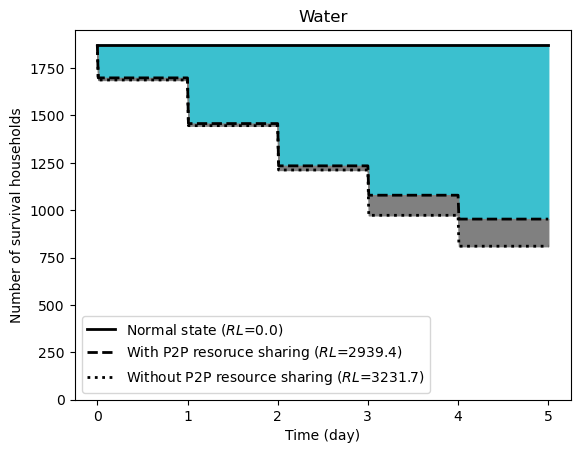

In [34]:
# plot the results
plt.plot(time_stamps, survival_curve_normal, color='k', linestyle='-', linewidth=2, label=f'Normal state ($RL$=0.0)')
plt.plot(time_stamps, survival_curve_with_sharing, color='k', linestyle='--', linewidth=2, label=f'With P2P resoruce sharing ($RL$={resilience_loss_with_sharing:.1f})')
plt.plot(time_stamps, survival_curve_without_sharing, color='k', linestyle='dotted', linewidth=2, label=f'Without P2P resource sharing ($RL$={resilience_loss_without_sharing:.1f})')
plt.fill_between(time_stamps, survival_curve_with_sharing, survival_curve_normal, color='#3BC0CF', alpha=1)
plt.fill_between(time_stamps, survival_curve_without_sharing, survival_curve_with_sharing, color='grey', alpha=1)

plt.xlabel('Time (day)')
plt.ylabel('Number of survival households')
plt.ylim(0, 1950)
plt.title('Water')
plt.legend(loc='lower left')